install required Python packages

In [107]:
!pip install pandas matplotlib seaborn

Import Required Libraries

In [108]:
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

mount the google drive

In [109]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


read from google drive

In [110]:
df = pd.read_json("/content/drive/My Drive/house_3.json")
# Display the first few rows to understand the structure of the dataset
print(df.head())


                                             address  \
0  შარტავას ქუჩა, Saburtalo, Saburtalo District, ...   
1                              Rustavi, Lower Kartli   
2  Queen Ketevan Avenue, Isani, Isani District, T...   
3  კრწანისის ქუჩა, Ortatchala Street, Ortachala, ...   
4  ორთაჭალის ქ, Ortachala, Krtsanisi District, Tb...   

                                        product_tree         time  views  \
0  Newly finished apartment for sale,Tbilisi,Sabu...  Today 12:33    622   
1  Older finished apartment for sale,Lower Kartli...  Today 11:40    276   
2  Newly finished apartment for sale,Tbilisi,Isan...  Today 13:27   1226   
3  Newly finished apartment for sale,Tbilisi,Krts...  Today 13:33   3309   
4  Newly finished apartment for sale,Tbilisi,Krts...  Today 13:32   1484   

                               title          id price_gel price_usd  \
0  Newly finished apartment for sale  : 10541934   107,100    32,500   
1  Older finished apartment for sale  : 10680693    87,300    

Data Cleaning start, Handling Missing Values

In [111]:
from sklearn.impute import SimpleImputer


# Handle categorical columns
categorical_columns = ['amenities', 'bedroom', 'description', 'floor', 'id',
                       'poster_id', 'poster_type', 'product_tree', 'room',
                       'time', 'title']

# Convert categorical columns to strings and impute missing values
for col in categorical_columns:
    df[col] = df[col].astype(str)
    if df[col].isnull().sum() > 0:
        imputer = SimpleImputer(strategy='most_frequent')
        df[col] = imputer.fit_transform(df[[col]])

# Handle numeric columns
numeric_columns = ['price_gel', 'price_usd', 'space', 'views']

for col in numeric_columns:
    if df[col].isnull().sum() > 0:
        imputer = SimpleImputer(strategy='median')
        df[col] = imputer.fit_transform(df[[col]])

# Handle latitude and longitude columns
df['latitude'] = df['latitude'].fillna(df['latitude'].mean())
df['longitude'] = df['longitude'].fillna(df['longitude'].mean())

# Display the cleaned data
print("Data after handling missing values:\n", df.head())

Data after handling missing values:
                                              address  \
0  შარტავას ქუჩა, Saburtalo, Saburtalo District, ...   
1                              Rustavi, Lower Kartli   
2  Queen Ketevan Avenue, Isani, Isani District, T...   
3  კრწანისის ქუჩა, Ortatchala Street, Ortachala, ...   
4  ორთაჭალის ქ, Ortachala, Krtsanisi District, Tb...   

                                        product_tree         time  views  \
0  Newly finished apartment for sale,Tbilisi,Sabu...  Today 12:33    622   
1  Older finished apartment for sale,Lower Kartli...  Today 11:40    276   
2  Newly finished apartment for sale,Tbilisi,Isan...  Today 13:27   1226   
3  Newly finished apartment for sale,Tbilisi,Krts...  Today 13:33   3309   
4  Newly finished apartment for sale,Tbilisi,Krts...  Today 13:32   1484   

                               title          id price_gel price_usd  \
0  Newly finished apartment for sale  : 10541934   107,100    32,500   
1  Older finished apartme

Convert Data Types and Clean Up Text

In [112]:
# Convert text fields to proper cases and strip unnecessary whitespace
df['address'] = df['address'].str.title().str.strip()
df['description'] = df['description'].str.strip().str.replace(r'\s+', ' ', regex=True)
df['title'] = df['title'].str.title().str.strip()

# Convert price columns to numeric after removing commas
df['price_gel'] = df['price_gel'].str.replace(',', '').astype(float)
df['price_usd'] = df['price_usd'].str.replace(',', '').astype(float)

# Convert space to numeric and handle any erroneous values
df['space'] = df['space'].str.extract(r'(\d+\.?\d*)').astype(float)
df['space'].fillna(df['space'].median(), inplace=True)  # Use median space where missing

# Convert views to integer, filling missing with the median
df['views'] = df['views'].fillna(df['views'].median()).astype(int)


Verification for data cleaning

In [113]:
#Check for Missing Values
missing_values = df.isnull().sum()
print("Missing Values After Cleaning:\n", missing_values)

#Check Data Types
print("\nData Types After Cleaning:\n", df.dtypes)

# Check for Duplicates
duplicate_rows = df.duplicated().sum()
print("\nNumber of Duplicate Rows After Cleaning:", duplicate_rows)

# Check for Logical Consistency
# Ensure that price_usd, space, and views are within logical ranges
invalid_prices = df[(df['price_usd'] <= 0) | (df['price_gel'] <= 0)]
invalid_space = df[df['space'] <= 0]
invalid_views = df[df['views'] < 0]

print("\nRows with Invalid Prices:\n", invalid_prices)
print("\nRows with Invalid Space:\n", invalid_space)
print("\nRows with Invalid Views:\n", invalid_views)

# Review Summary Statistics
print("\nSummary Statistics After Cleaning:\n", df.describe())


Missing Values After Cleaning:
 address         0
product_tree    0
time            0
views           0
title           0
id              0
price_gel       0
price_usd       0
space           0
room            0
bedroom         0
floor           0
description     0
amenities       0
latitude        0
longitude       0
poster_type     0
poster_id       0
dtype: int64

Data Types After Cleaning:
 address          object
product_tree     object
time             object
views             int64
title            object
id               object
price_gel       float64
price_usd       float64
space           float64
room             object
bedroom          object
floor            object
description      object
amenities        object
latitude        float64
longitude       float64
poster_type      object
poster_id        object
dtype: object

Number of Duplicate Rows After Cleaning: 0

Rows with Invalid Prices:
 Empty DataFrame
Columns: [address, product_tree, time, views, title, id, price_gel, 

Address Outliers

In [114]:
import numpy as np

# Handling outliers by capping them at the 1st and 99th percentiles
for col in ['price_gel', 'price_usd', 'space', 'views']:
    lower_bound = df[col].quantile(0.01)
    upper_bound = df[col].quantile(0.99)
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

print("Data after handling outliers:\n", df.describe())


Data after handling outliers:
               views     price_gel      price_usd         space      latitude  \
count  41663.000000  4.166300e+04   41663.000000  41663.000000  41663.000000   
mean     317.375044  2.780698e+05   84389.454432     86.311593     41.727149   
std      561.517569  2.196086e+05   66646.690208     46.465356      0.088848   
min        8.000000  5.270000e+04   16000.000000     27.779800     40.359141   
25%       40.000000  1.417000e+05   43000.000000     55.000000     41.705586   
50%      108.000000  2.076000e+05   63000.000000     74.000000     41.722471   
75%      321.000000  3.295000e+05  100000.000000    104.000000     41.732551   
max     3494.380000  1.293416e+06  392520.000000    280.000000     46.218059   

          longitude  
count  41663.000000  
mean      44.496279  
std        0.887860  
min       38.829869  
25%       44.742562  
50%       44.769620  
75%       44.798019  
max       47.238277  


Explore Relationships

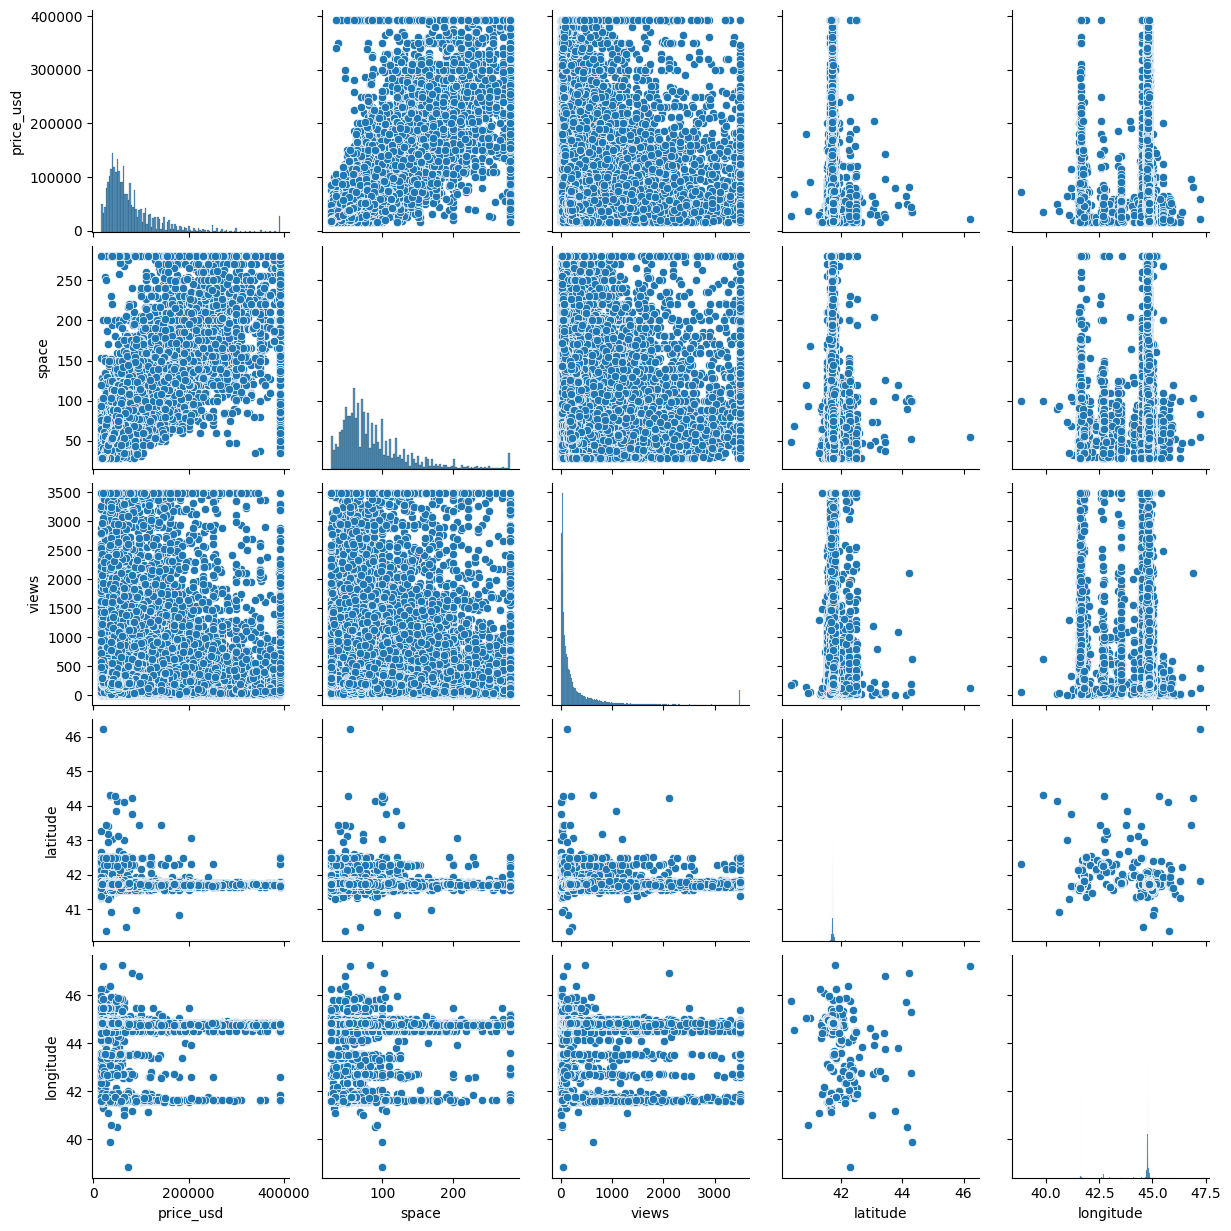

In [115]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pairplot to explore relationships between key variables
sns.pairplot(df[['price_usd', 'space', 'views', 'latitude', 'longitude']])
plt.show()


Clustering Analysis

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


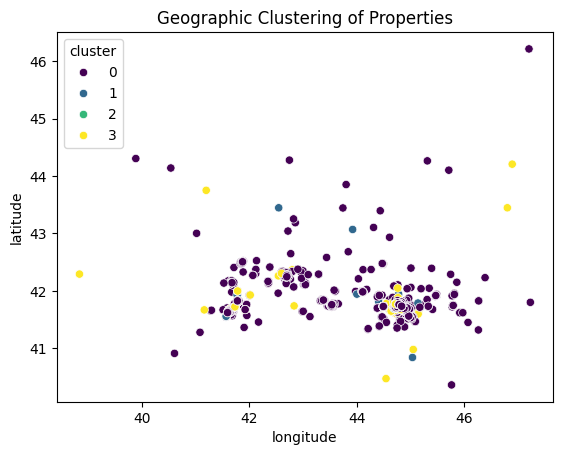

In [116]:
from sklearn.cluster import KMeans

# Clustering properties based on price, space, and views
kmeans = KMeans(n_clusters=4)
df['cluster'] = kmeans.fit_predict(df[['price_usd', 'space', 'views']])

# Visualize clusters
sns.scatterplot(x='longitude', y='latitude', hue='cluster', data=df, palette='viridis')
plt.title('Geographic Clustering of Properties')
plt.show()
